In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns
import scipy

from IPython.display import clear_output

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys

sys.path.append("..")

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice, generate_time_one_time_two

/Users/nicholasmartin/Programming/Research/optimal-execution-kernel-decomposition/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
config = Config("config.yaml")

In [3]:
rng = np.random.default_rng(123)

kernel_num_timesteps = 1_000
final_time = 1
initial_price = 1
decomp_dim = 3
num_episodes = 250_000
kernel_batch_size = 64

kernel_dt = final_time / kernel_num_timesteps

# kernel_function = lambda x,y: ((np.abs((x-y))+(dt))**(0.51-1))/scipy.special.gamma(0.51)
# kernel_function = lambda x, y: np.exp(-((x - y) ** 2) / (0.1))
# kernel_function = lambda x,y: 10*np.exp(-np.abs((x-y)/(0.1)))
kernel_function = lambda x, y: 1 / (1 + np.abs(x - y) ** 0.5)
K0 = kernel_function(0, 0)

# Generate Data

# NN Approach

In [4]:
learning_rate = 1e-4
kernel_network = MLP(decomp_dim=decomp_dim,
                     learn_price_impact=False)
optimizer = torch.optim.Adam(
    params=kernel_network.parameters(), 
    lr=learning_rate
)

In [5]:
loss_list = []
for i in tqdm(range(num_episodes)):

    upper_bound = kernel_num_timesteps*2

    # if i % 100_000 == 0:
    #     lower_bound = int((upper_bound)*0.99)
    # else:
    #     lower_bound = 0

    # val_one = rng.uniform(lower_bound+1, upper_bound, kernel_batch_size)
    # val_two = np.array([rng.uniform(lower_bound, _) for _ in val_one])
    val_one = rng.uniform(0, kernel_num_timesteps*2, kernel_batch_size)
    val_two = rng.uniform(-0, kernel_num_timesteps*2, kernel_batch_size)

    time_one = (
        torch.FloatTensor(val_one).reshape(-1, 1) * kernel_dt
    )
    time_two = (
        torch.FloatTensor(val_two).reshape(-1, 1) * kernel_dt
    )
    
    K_one_two = kernel_network.approx_func(time_one, time_two).flatten()
    K_one_one = kernel_network.approx_func(time_one, time_one).flatten()

    true_val = torch.FloatTensor(
        kernel_function(time_one.detach().numpy(), time_two.detach().numpy())
    ).flatten()

    true_error = torch.abs(true_val - K_one_two)
    one_error = torch.abs(K0 - K_one_one)

    loss = (true_error).mean()

    loss_list.append(loss.detach().item())

    kernel_network.zero_grad()
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    kernel_network.zero_grad()
    optimizer.zero_grad()

    if i % 100 == 0:
        clear_output(wait=True)
        s = 0.5
        s_val = kernel_num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []

        for _ in range(0, int(s_val)):
            k_s_t = kernel_network.approx_func(
                torch.FloatTensor([s_val * kernel_dt]).reshape(-1, 1),
                torch.FloatTensor([_ * kernel_dt]).reshape(1, -1),
            )
            kernel_plot.append(k_s_t.detach().item())

        for _ in range(0, int(s_val)):
            val = kernel_function(_ * kernel_dt, s_val*kernel_dt)
            kernel_plot_two.append(val)

        plt.title(i)
        plt.plot(kernel_plot_two, label="True")
        plt.plot(kernel_plot, label="Calibrated")
        plt.legend()
        plt.show()

KeyboardInterrupt: 

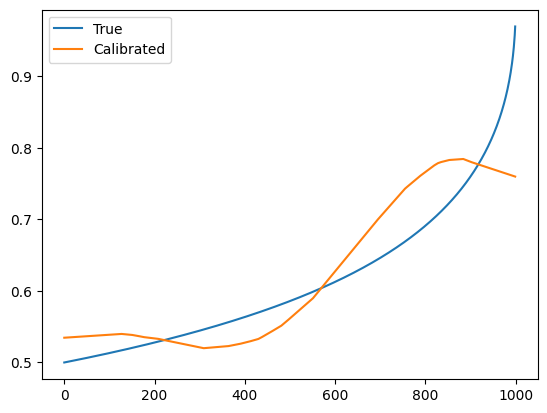

In [ ]:
s_val = 1000
kernel_plot = []
kernel_plot_two = []

for i in range(0, 1000):
    k_s_t = kernel_network.approx_func(
        torch.FloatTensor([s_val * kernel_dt]).reshape(-1, 1),
        torch.FloatTensor([i * kernel_dt]).reshape(1, -1),
    )
    kernel_plot.append(k_s_t.detach().item())

partial_func = partial(kernel_function, y=s_val * kernel_dt)
for i in range(0, 1000):
    val = partial_func(i * kernel_dt)
    kernel_plot_two.append(val)

plt.plot(kernel_plot_two, label="True")
plt.plot(kernel_plot, label="Calibrated")
plt.legend()
plt.show()

# Learning Price Impact

In [ ]:
pi_num_paths = 1
pi_num_timesteps = 100
pi_num_episodes = 5_000
pi_batch_size = 1

pi_dt = final_time/pi_num_episodes

kappa_true = 1
permenant_price_impact_func = lambda x: kappa_true * np.sign(x) * np.sqrt(np.abs(x))

inital_prices = np.ones((1, pi_num_paths)) * initial_price
nu_vals = rng.integers(-100, 100, size=(pi_num_timesteps, pi_num_paths))
min_pi = kappa_true*nu_vals.min()
max_pi = kappa_true*nu_vals.max()

sigma_true = 0.01
sim_prices, noise_process = non_markovian_midprice(
    inital_prices=inital_prices,
    permenant_price_impact_func=permenant_price_impact_func,
    nu_vals=nu_vals,
    kernel_function=kernel_function,
    dt=pi_dt,
    rng=rng,
    num_paths=pi_num_paths,
    num_timesteps=pi_num_timesteps,
    sigma=sigma_true,
)

In [ ]:
pi_learning_rate = 1e-4

pi_network = MLP(decomp_dim=decomp_dim, learn_price_impact=True, sigma_start=0.1)
pi_mt_loss = MultiTaskLoss(num_losses=1, lagrangian=True)

pi_optimizer = torch.optim.Adam(
    params=[*pi_network.parameters(), *pi_mt_loss.parameters()], lr=pi_learning_rate
)

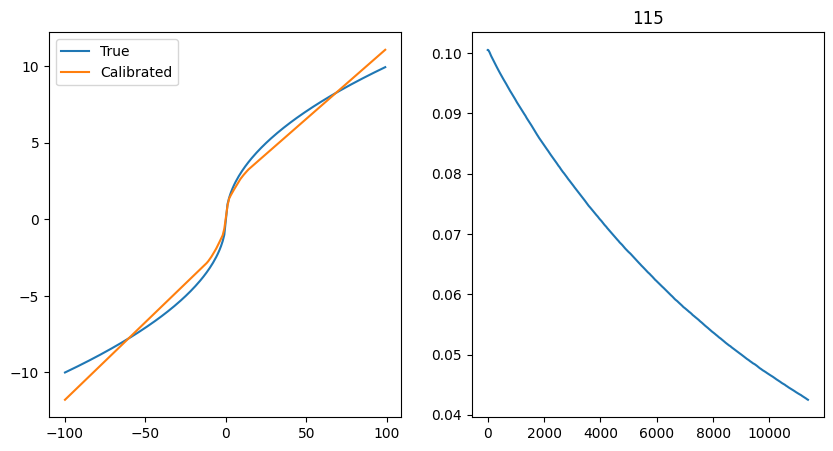

KeyboardInterrupt: 

In [ ]:
kernel_network.eval()
optimizer.zero_grad()

loss_vals = {}
sigma_tracker = {}
kappa_tracker = {}
for episode in tqdm(range(num_episodes), position=0, leave=True):
    loss_vals[episode] = []
    sigma_tracker[episode] = []
    kappa_tracker[episode] = []
    for batch_index in range(1, int(pi_num_paths / pi_batch_size) + 1):

        lower_bound = int((batch_index - 1) * pi_batch_size)
        upper_bound = int((batch_index) * pi_batch_size)

        B_n_t = torch.zeros((pi_batch_size, decomp_dim))

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        shuffeled_timesteps = np.arange(1, pi_num_timesteps - 1)

        rng.shuffle(shuffeled_timesteps)

        for timestep in shuffeled_timesteps:

            true_vals_t = torch.FloatTensor(true_vals[timestep, :])
            true_vals_t_plus_one = torch.FloatTensor(true_vals[timestep + 1, :])

            batch_nu_vals_t = torch.FloatTensor(batch_nu_vals[timestep])
            price_impacts = pi_network.permenant_price_impact_func(
                batch_nu_vals_t
            ).reshape(pi_batch_size)

            time_tensor = torch.FloatTensor([timestep * pi_dt])
            f_vals = kernel_network(time_tensor).detach()
            K_t_t = torch.FloatTensor([1])

            # Calculate Second f(X_t, t; \theta) term
            # Calcutate f_n'(t)

            all_time_tensor = (torch.arange(0, timestep) * pi_dt).reshape(-1, 1)
            B_n_t = torch.zeros((1, pi_batch_size, decomp_dim))
            
            d_B_n_s = (
                kernel_network(all_time_tensor).reshape(timestep, 1, decomp_dim)
                * pi_network.permenant_price_impact_func(torch.FloatTensor(batch_nu_vals[:timestep]).reshape(timestep, pi_batch_size, 1)).reshape(
                timestep, pi_batch_size, 1
            )
            * pi_dt
            )

            B_n_t = torch.vstack([B_n_t, d_B_n_s])
            B_n_t = torch.sum(B_n_t[:-1], axis=0)

            delta = torch.FloatTensor([pi_dt])
            time_minus_delta = time_tensor - delta
            time_plus_delta = time_tensor + delta
            f_prime_vals = (
                (
                    (kernel_network(time_plus_delta) - kernel_network(time_minus_delta))
                    / (2 * delta)
                )
                .flatten()
            ).detach()

            # Calculate first f(X_t, t; \theta) term
            f_x_t_one = price_impacts.reshape(pi_batch_size) * K_t_t.detach()

            f_x_t_two = (
                B_n_t.reshape(pi_batch_size, decomp_dim)
                * f_prime_vals.reshape(1, decomp_dim)
            ).sum(dim=1)

            f_x_t = f_x_t_one + f_x_t_two

            L_x_t = pi_network.sigma

            ########################################################################
            term_one = 0.5 * torch.log(torch.abs(2 * torch.pi * (L_x_t**2) * pi_dt))
            ########################################################################
            term_two = (((true_vals_t_plus_one - true_vals_t) - f_x_t * pi_dt) ** 2) / (
                2 * pi_dt * (L_x_t**2)
            )
            ########################################################################
            likely_hood_loss = (term_one + term_two).mean()

            sigma_tracker[episode].append(pi_network.sigma.detach().item())
            ########################################################################
            ########################################################################
            ########################################################################
            # Price Impact Function Constraints
            # Zero price impace at zero flow
            zero_nus = torch.zeros(size=(pi_batch_size, 1))
            zero_pi = pi_network.permenant_price_impact_func(zero_nus)

            pi_loss_one = torch.abs(zero_pi).mean()**2
            ########################################################################
            delta = 0.1
            zero_grad = (
                pi_network.permenant_price_impact_func(zero_nus + delta)
                - pi_network.permenant_price_impact_func(zero_nus - delta)
            ) / (2 * pi_dt)
            ########################################################################
            # Ensure g'(0) is not toooooo whacky
            pi_loss_one_grad = torch.maximum(
                torch.zeros_like(zero_grad), torch.abs(zero_grad)-10
            ).mean()**2
            # Ensure g'(0) > 0
            pi_loss_two_grad = torch.maximum(
                torch.zeros_like(zero_grad), -zero_grad
            ).mean()**2
            ########################################################################
            ########################################################################
            ########################################################################
            random_nus = torch.FloatTensor(rng.integers(-100, 100, size=(pi_batch_size, 1)))
            # Want the grad to be negative: g'(nu_t) > 0
            delta = 0.1
            grad_pi = (
                pi_network.permenant_price_impact_func(random_nus + delta)
                - pi_network.permenant_price_impact_func(random_nus - delta)
            ) / (2 * delta)

            pi_loss_two = torch.maximum(torch.zeros_like(grad_pi), -grad_pi).mean()**2
            ########################################################################
            ########################################################################
            ########################################################################
            random_nus = torch.FloatTensor(rng.integers(-100, 100, size=(pi_batch_size, 1)))
            lesser_nu_pi = pi_network.permenant_price_impact_func(-torch.abs(random_nus))
            greater_nu_pi = pi_network.permenant_price_impact_func(torch.abs(random_nus))
            ########################################################################
            # Ensure that g(-|nu|)<0 and g(|nu|)>0
            lesser_loss = torch.maximum(
                torch.zeros_like(lesser_nu_pi), lesser_nu_pi
            ).flatten()
            greater_loss = torch.maximum(
                torch.zeros_like(greater_nu_pi), -greater_nu_pi
            ).flatten()

            pi_loss_three = ((lesser_loss.sum() + greater_loss.sum()) / (pi_batch_size))**2
            ########################################################################
            random_nus = torch.FloatTensor(rng.integers(-100, 100, size=(pi_batch_size, 1)))
            random_pi = pi_network.permenant_price_impact_func(random_nus)

            lesser_loss_two = torch.maximum(
                torch.zeros_like(random_pi), min_pi - random_pi
            ).flatten()

            greater_loss_two = torch.maximum(
                torch.zeros_like(random_pi), random_pi - max_pi
            ).flatten()

            pi_loss_four = ((lesser_loss_two.sum() + greater_loss_two.sum())/(pi_batch_size))**2
            ########################################################################
            random_nus = torch.FloatTensor(rng.integers(-100, 100, size=(pi_batch_size, 1)))

            pi_loss_five = torch.abs(
                pi_network.permenant_price_impact_func(random_nus)
                + pi_network.permenant_price_impact_func(-random_nus)
            ).mean()**2
            ########################################################################
            ########################################################################
            ########################################################################

            loss_tensor = torch.hstack(
                [
                    likely_hood_loss,
                    # pi_loss_one,
                    # # pi_loss_one_grad,
                    # # pi_loss_two_grad,
                    # pi_loss_two,
                    # pi_loss_three,
                    # # pi_loss_four,
                    # pi_loss_five
                ]
            )

            if len(loss_tensor) == 1:
                loss = loss_tensor.mean()
            else:
                loss = pi_mt_loss(loss_tensor)

            ########################################################################
            ########################################################################
            ########################################################################
            loss_vals[episode].append(
                {   
                    'mt_loss': loss.detach().item(),
                    **{i: _.detach().item() for i, _ in enumerate(loss_tensor)}
                }
            )
            pi_network.zero_grad()
            pi_optimizer.zero_grad()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(pi_network.parameters(), 1)
            pi_optimizer.step()

            pi_network.zero_grad()
            pi_optimizer.zero_grad()

    # scheduler.step()

    if episode % 5 == 0:
        clear_output(wait=True)
        pi_plot = []
        pi_plot_true = []

        for plot_val in range(-100, 100):
            pred_pi = pi_network.permenant_price_impact_func(
                torch.FloatTensor([plot_val])
            )
            pi_plot.append(pred_pi.detach().item())

        for plot_val in range(-100, 100):
            val = permenant_price_impact_func(plot_val)
            pi_plot_true.append(val)

        fig, ax = plt.subplots(1,2, figsize=(10,5))

        ax[0].plot(range(-100, 100), pi_plot_true, label="True")
        ax[0].plot(range(-100, 100), pi_plot, label="Calibrated")
        ax[0].legend()

        ax[1].plot(np.hstack([_ for _ in sigma_tracker.values()]))

        plt.title(episode)
        plt.show()

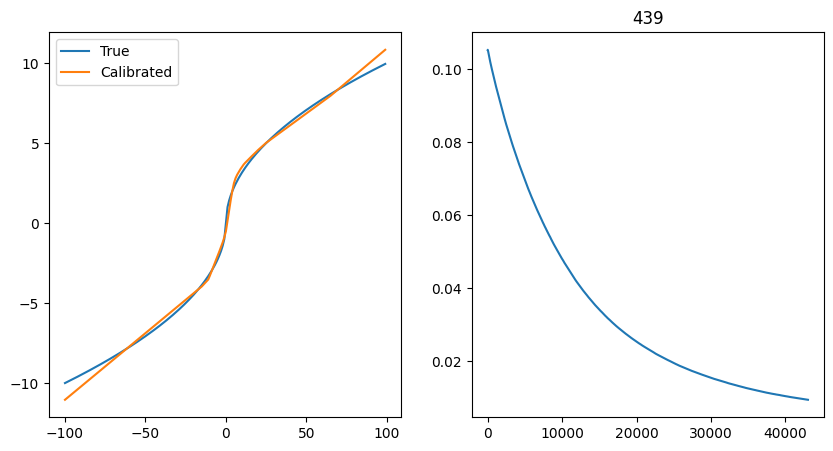

In [ ]:
pi_plot = []
pi_plot_true = []

for plot_val in range(-100, 100):
    pred_pi = pi_network.permenant_price_impact_func(
        torch.FloatTensor([plot_val])
    )
    pi_plot.append(pred_pi.detach().item())

for plot_val in range(-100, 100):
    val = permenant_price_impact_func(plot_val)
    pi_plot_true.append(val)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(range(-100, 100), pi_plot_true, label="True")
ax[0].plot(range(-100, 100), pi_plot, label="Calibrated")
ax[0].legend()

ax[1].plot(np.hstack([_ for _ in sigma_tracker.values()]))

plt.title(episode)
plt.show()

# Optimal Trading